# Problem 3: 0-1 Knapsack problem solved with BA

In [2]:
# import
import pandas as pd
import re
import numpy as np, time
import matplotlib.pyplot as plt

### 0. Pars .DAT files from OR-Library -> mknap2.txt file

In [3]:
def load_mknap2_instances(filepath, select_names=None):
    """
    Robust parser for OR-Library mknap2.txt dataset.
    Extracts problem blocks (WEING, WEISH, etc.) and returns a dict of DataFrames.
    """
    with open(filepath, 'r') as f:
        lines = [line.rstrip() for line in f]

    instances = {}
    current_name = None
    current_block = []

    for line in lines:
        line_stripped = line.strip()

        if line_stripped.lower().startswith("problem"):
            # Save the previous problem block
            if current_name and current_block:
                instances[current_name] = "\n".join(current_block)
                current_block = []

            # Capture the new instance name (e.g., WEING1.DAT)
            match = re.search(r"problem\s+(\S+)", line_stripped, re.IGNORECASE)
            if match:
                current_name = match.group(1).strip().upper()

        elif line_stripped.startswith("+"):
            continue  # skip decorative lines

        elif current_name:
            current_block.append(line_stripped)

    # Add the final instance
    if current_name and current_block:
        instances[current_name] = "\n".join(current_block)

    # Optional filtering
    if select_names:
        select_names = [n.upper() for n in select_names]
        instances = {k: v for k, v in instances.items() if k in select_names}

    parsed = {}
    for name, text in instances.items():
        parsed[name] = parse_single_instance_block(text, name)

    return parsed


def parse_single_instance_block(block_text, name=None):
    """
    Parses a single instance's text block (no 'problem' line) into a DataFrame.
    Handles any leading non-numeric lines like '++++'.
    """
    lines = [l.strip() for l in block_text.splitlines() if l.strip()]
    # Skip any non-numeric first lines
    while lines and not re.match(r"^\d+", lines[0]):
        lines.pop(0)

    if len(lines) == 0:
        raise ValueError(f"No numeric data found for instance {name}")

    # Parse m and n
    m, n = map(int, lines[0].split())

    # --- Profits ---
    current = 1
    profits = []
    while len(profits) < n and current < len(lines):
        profits.extend(map(float, lines[current].split()))
        current += 1

    # --- Weights ---
    weights = []
    for _ in range(m):
        w = []
        while len(w) < n and current < len(lines):
            w.extend(map(float, lines[current].split()))
            current += 1
        weights.append(w[:n])

    # --- Capacities ---
    capacities = list(map(float, lines[current].split()))
    current += 1

    # --- Optimal value (last numeric line) ---
    optimal_value = None
    for line in reversed(lines):
        parts = line.split()
        if len(parts) == 1:  # only one number → likely the optimal value
            try:
                optimal_value = float(parts[0])
                break
            except ValueError:
                continue


    # --- Build DataFrame ---
    df = pd.DataFrame({'Item': range(1, n + 1), 'Profit': profits})
    for j in range(m):
        df[f'Weight_{j+1}'] = weights[j]

    df.attrs['capacities'] = capacities
    df.attrs['optimal_value'] = optimal_value
    df.attrs['m'] = m
    df.attrs['n'] = n
    df.attrs['name'] = name

    return df


In [4]:
select_names = [
    "WEING1.DAT",
    "WEISH01.DAT",
    "WEISH05.DAT",
    "WEISH14.DAT",
    "WEISH20.DAT",
    "WEISH28.DAT"
]

instances = load_mknap2_instances("mknap2.txt", select_names=select_names)
print(f"✅ Parsed {len(instances)} instances successfully!")


✅ Parsed 6 instances successfully!


In [5]:
for name, df in instances.items():
    print(f"\n{name}: {df.attrs['n']} items, {df.attrs['m']} constraints")
    print("Capacities:", df.attrs['capacities'])
    print("Optimal value:", df.attrs['optimal_value'])
    print(df.head(3))



WEING1.DAT: 28 items, 2 constraints
Capacities: [141278.0]
Optimal value: 141278.0
   Item   Profit  Weight_1  Weight_2
0     1   1898.0     600.0      30.0
1     2    440.0     600.0      20.0
2     3  22507.0      45.0     125.0

WEISH01.DAT: 30 items, 5 constraints
Capacities: [4554.0]
Optimal value: 4554.0
   Item  Profit  Weight_1  Weight_2  Weight_3  Weight_4  Weight_5
0     1   360.0     400.0       8.0       3.0      21.0      94.0
1     2    83.0     500.0      66.0      74.0      40.0      86.0
2     3    59.0     500.0      98.0      88.0       0.0      80.0

WEISH05.DAT: 30 items, 5 constraints
Capacities: [4514.0]
Optimal value: 4514.0
   Item  Profit  Weight_1  Weight_2  Weight_3  Weight_4  Weight_5
0     1   360.0     540.0       8.0       3.0      21.0      94.0
1     2    83.0     240.0      66.0      74.0      40.0      86.0
2     3    59.0     480.0      98.0      88.0       0.0      80.0

WEISH14.DAT: 60 items, 5 constraints
Capacities: [6954.0]
Optimal value: 6954

### 1. Define parameters and instance

In [6]:
# all 6 instances
experiment_instances = {
    "small_1": instances["WEING1.DAT"],
    "small_2": instances["WEISH01.DAT"],
    "medium_1": instances["WEISH05.DAT"],
    "medium_2": instances["WEISH14.DAT"],
    "large_1": instances["WEISH20.DAT"],
    "large_2": instances["WEISH28.DAT"]
}

# balanced parameter set
params_balanced = {
    "n": 50,        # number of scout bees
    "nb": 10,       # number of best sites selected
    "ne": 3,        # number of elite sites
    "nre": 10,      # recruited bees around elite sites
    "nrb": 5,       # recruited bees around other best sites
    "ngh": 2,       # neighbourhood size (bits flipped)
    "max_iter": 200,
    "verbose": False
}

# explorative parameter set
params_exploration = {
    "n": 100,       # explore more of the search space
    "nb": 20,
    "ne": 5,
    "nre": 10,
    "nrb": 10,
    "ngh": 4,       # explore wider neighbourhoods
    "max_iter": 200,
    "verbose": False
}

# exploitive parameter set
params_exploitation = {
    "n": 40,        # smaller population, more focused
    "nb": 8,
    "ne": 4,
    "nre": 20,      # more recruited bees = deeper local search
    "nrb": 10,
    "ngh": 1,       # tight neighbourhood
    "max_iter": 200,
    "verbose": False
}

# Combine into a single dictionary for experiments
parameter_sets = {
    "baseline": params_balanced,
    "exploration": params_exploration,
    "exploitation": params_exploitation
}


### 2. Core function

In [7]:
def bees_knapsack(values, weights, capacity, n, nb, ne, nre, nrb, ngh, max_iter, verbose):
    """


    :param values: array of item profits
    :param weights: array of item weights
    :param capacity: max total weight allowed
    :param n: population size
    :param nb: number of best sites selected
    :param ne: number of elite sites
    :param nre: number of bees recruited for elite sites
    :param nrb: number of bees recruited for normal sites
    :param ngh: neighbourhood size
    :param max_iter: max iterations
    :param verbose: whether to print progress

    :return best_value: best profit found
    :return best_solution: chosen items (binary vector)
    :return history: list of the best fitness per iteration
    :return runtime: how long it took
    """

    # 1 - initialise population
    start = time.time()
    n_items = len(values)
    population = np.random.randint(0, 2, (n, n_items)) # random generation of initial population

    # 2 - evaluate fitness
    def evaluate(solution, values, weights, capacity):
        total_w = np.dot(solution, weights)
        total_v = np.dot(solution, values)

        # repair if weight is higher than capacity
        if total_w > capacity:
            ones = np.where(solution == 1)[0]
            np.random.shuffle(ones)
            for idx in ones:
                if total_w <= capacity:
                    break
                solution[idx] = 0
                total_w = np.dot(solution, weights)
                total_v = np.dot(solution, values)
        return total_v, solution

    fitness = np.zeros(n)
    for i in range(n):
        val, _ = evaluate(population[i].copy(), values, weights, capacity)
        fitness[i] = val

    best_idx = np.argmax(fitness)
    best_value = fitness[best_idx]
    best_solution = population[best_idx].copy()

    # 3 - iterate through population
    history = [best_value]
    for it in range(max_iter):
        # A - sort
        idx_sorted = np.argsort(fitness)[::-1]
        population = population[idx_sorted]
        fitness = fitness[idx_sorted]

        new_population = []
        new_fitness = []

        # B - neighbourhood search
        for i in range(nb):
            site = population[i].copy()
            recruits = nre if i < ne else nrb
            best_site_val = fitness[i]
            best_site_sol = site.copy()

            for _ in range(recruits):
                # create neighbour by flipping some bits
                neigh = site.copy()
                flip_idx = np.random.choice(n_items, size=np.random.randint(1, ngh+1), replace=False)
                neigh[flip_idx] = 1 - neigh[flip_idx]
                val, neigh = evaluate(neigh, values, weights, capacity)
                if val > best_site_val:
                    best_site_val = val
                    best_site_sol = neigh.copy()

            new_population.append(best_site_sol)
            new_fitness.append(best_site_val)

        # C - random scouts (exploration)
        scouts = np.random.randint(0, 2, (n - nb, n_items))
        for s in scouts:
            val, s = evaluate(s, values, weights, capacity)
            new_population.append(s)
            new_fitness.append(val)

        # D - update population
        population = np.array(new_population)
        fitness = np.array(new_fitness)

        # E - track global best
        iteration_best = np.max(fitness)
        if iteration_best > best_value:
            best_value = iteration_best
            best_solution = population[np.argmax(fitness)].copy()

        history.append(best_value)
        if verbose and it % 10 == 0:
            print(f"Iter {it:03d} | Best = {best_value:.2f}")

    runtime = time.time() - start
    return best_value, best_solution, history, runtime


### 4. Run experiment

In [8]:
import pandas as pd
import numpy as np
import time

def run_experiment(instances, parameter_sets):
    """
    Runs Bees Algorithm for all instances and parameter sets.
    Returns a DataFrame summarizing results.
    """
    results = []

    for param_label, params in parameter_sets.items():
        print(f"\n🚀 Running Bees Algorithm ({param_label.upper()}) configuration...")

        for inst_label, df in instances.items():
            print(f"   → Instance: {inst_label} ({df.attrs['n']} items, {df.attrs['m']} constraints)")

            # Extract data
            values = df["Profit"].values
            weights = df[[col for col in df.columns if col.startswith("Weight_")][0]].values
            capacity = df.attrs["capacities"][0]

            # Run Bees Algorithm
            start = time.time()
            best_val, best_sol, hist, runtime = bees_knapsack(values, weights, capacity, **params)
            total_runtime = time.time() - start

            # Evaluate metrics
            used_weight = np.dot(best_sol, weights)
            opt_val = df.attrs["optimal_value"]
            deviation = None if not opt_val else round(100 * (1 - best_val / opt_val), 4)

            results.append({
                "Instance": inst_label,
                "Parameter_Set": param_label,
                "Items": df.attrs["n"],
                "Constraints": df.attrs["m"],
                "Best_Value": best_val,
                "Optimal_Value": opt_val,
                "Deviation_%": deviation,
                "Used_Weight": used_weight,
                "Runtime_s": round(total_runtime, 3),
                "Iterations": params["max_iter"]
            })

    results_df = pd.DataFrame(results)
    return results_df


In [9]:
results_df = run_experiment(experiment_instances, parameter_sets)
display(results_df)



🚀 Running Bees Algorithm (BASELINE) configuration...
   → Instance: small_1 (28 items, 2 constraints)
   → Instance: small_2 (30 items, 5 constraints)
   → Instance: medium_1 (30 items, 5 constraints)
   → Instance: medium_2 (60 items, 5 constraints)
   → Instance: large_1 (70 items, 5 constraints)
   → Instance: large_2 (90 items, 5 constraints)

🚀 Running Bees Algorithm (EXPLORATION) configuration...
   → Instance: small_1 (28 items, 2 constraints)
   → Instance: small_2 (30 items, 5 constraints)
   → Instance: medium_1 (30 items, 5 constraints)
   → Instance: medium_2 (60 items, 5 constraints)
   → Instance: large_1 (70 items, 5 constraints)
   → Instance: large_2 (90 items, 5 constraints)

🚀 Running Bees Algorithm (EXPLOITATION) configuration...
   → Instance: small_1 (28 items, 2 constraints)
   → Instance: small_2 (30 items, 5 constraints)
   → Instance: medium_1 (30 items, 5 constraints)
   → Instance: medium_2 (60 items, 5 constraints)
   → Instance: large_1 (70 items, 5 const

,Instance,Parameter_Set,Items,Constraints,Best_Value,Optimal_Value,Deviation_%,Used_Weight,Runtime_s,Iterations
0,small_1,baseline,28,2,164045.0,141278.0,-16.1150,2225.0,0.256,200
1,small_2,baseline,30,5,5829.0,4554.0,-27.9974,3448.0,0.200,200
2,medium_1,baseline,30,5,5829.0,4514.0,-29.1316,3498.0,0.176,200
3,medium_2,baseline,60,5,9565.0,6954.0,-37.5467,6571.0,0.193,200
4,large_1,baseline,70,5,11466.0,9450.0,-21.3333,8212.0,0.199,200
5,large_2,baseline,90,5,13275.0,9492.0,-39.8546,7385.0,0.229,200
6,small_1,exploration,28,2,164045.0,141278.0,-16.1150,2225.0,0.695,200
7,small_2,exploration,30,5,5829.0,4554.0,-27.9974,3448.0,0.526,200
8,medium_1,exploration,30,5,5829.0,4514.0,-29.1316,3498.0,0.509,200
9,medium_2,exploration,60,5,9565.0,6954.0,-37.5467,6571.0,0.569,200


In [10]:
summary = (
    results_df.groupby("Parameter_Set")[["Deviation_%", "Runtime_s"]]
    .mean()
    .round(3)
    .reset_index()
)
display(summary)


,Parameter_Set,Deviation_%,Runtime_s
0,baseline,-28.663,0.209
1,exploitation,-28.663,0.317
2,exploration,-28.663,0.585


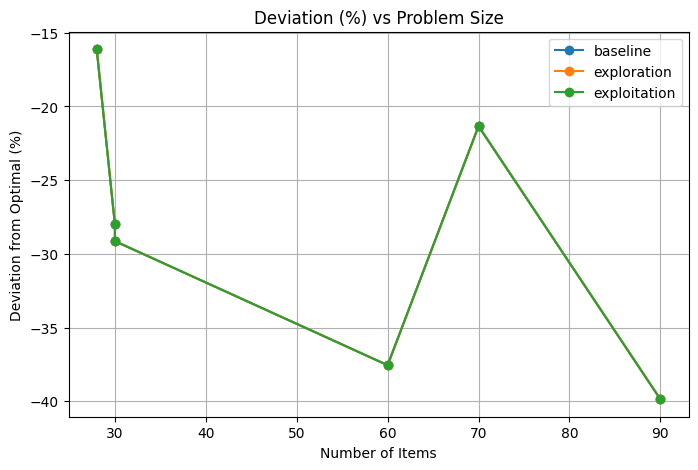

In [11]:
plt.figure(figsize=(8,5))
for param in results_df["Parameter_Set"].unique():
    subset = results_df[results_df["Parameter_Set"] == param]
    plt.plot(subset["Items"], subset["Deviation_%"], marker='o', label=param)

plt.title("Deviation (%) vs Problem Size")
plt.xlabel("Number of Items")
plt.ylabel("Deviation from Optimal (%)")
plt.legend()
plt.grid(True)
plt.show()
